<a href="https://colab.research.google.com/github/aymanxp/Handwritten-digit-Classification-using-Convolutional-Neural-Networks-CNN-with-PyTorch/blob/main/cnn_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
#Set up device agnostic code :
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# ***1.Load the torchvision.datasets.MNIST() train and test datasets.***

In [ ]:
train_data = MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="data", train=False, download=True, transform=ToTensor())

In [ ]:
#get the class names of the dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

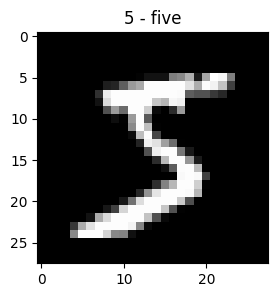

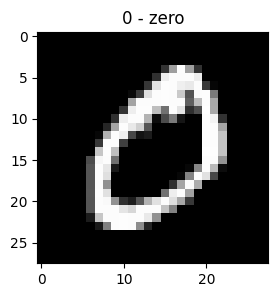

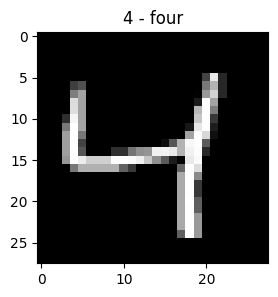

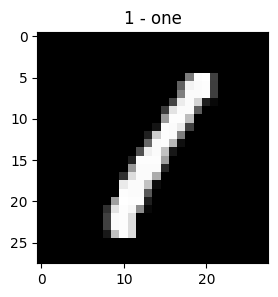

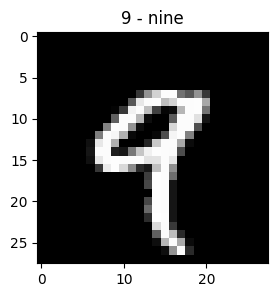

In [ ]:
#Visualize 5 samples of the MNIST training dataset
for i in range(5):
    img, label = train_data[i][0], train_data[i][1]
    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label]);

# **2.Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.**

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# **3.Create the model  (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/#article-pooling), also known as TinyVGG) capable of fitting on the MNIST dataset.**

In [ ]:
class cnn(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

In [ ]:
model = cnn(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

cnn(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# **4.Train the model**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
#Setup loss function, accuracy function and the omptimizer :
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [ ]:
epochs = 5
for epoch in tqdm(range(epochs)):
  ## Training loop :
  model.train()
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_pred, y)
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  ## Testing loop
  test_loss = 0
  test_acc = 0
  model.eval()
  for batch, (X_test, y_test) in enumerate(test_dataloader):
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)
    acc = accuracy_fn(y_pred, y_test)
    test_loss += loss
    test_acc += acc

  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)
  print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.4f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.4f}%")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.2236 | Train acc: 92.8067% | Test loss: 0.0868 | Test acc: 97.2244%
Epoch: 2 | Train loss: 0.0685 | Train acc: 97.8483% | Test loss: 0.0520 | Test acc: 98.3127%
Epoch: 3 | Train loss: 0.0530 | Train acc: 98.3300% | Test loss: 0.0469 | Test acc: 98.4425%
Epoch: 4 | Train loss: 0.0447 | Train acc: 98.6100% | Test loss: 0.0405 | Test acc: 98.7021%
Epoch: 5 | Train loss: 0.0390 | Train acc: 98.8200% | Test loss: 0.0450 | Test acc: 98.5623%


# **5.Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label**

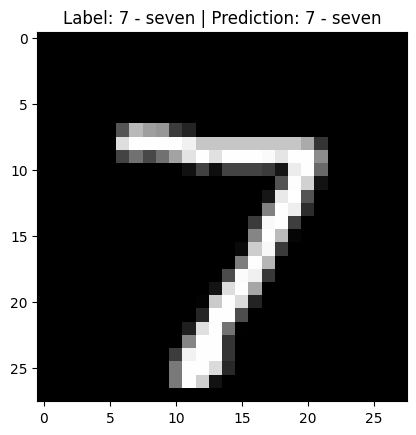

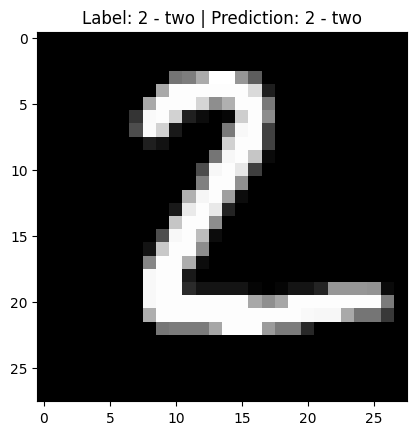

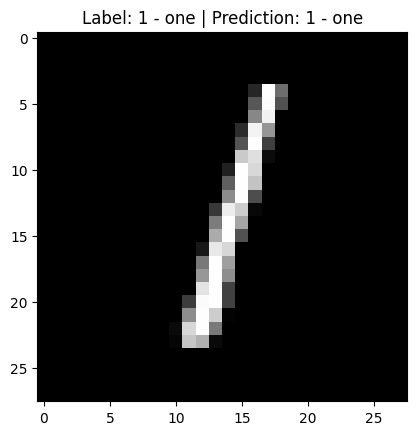

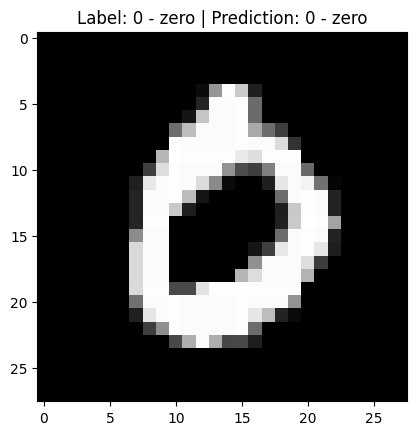

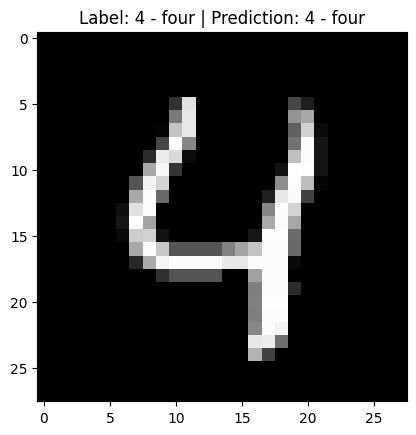

In [ ]:
for i in range(5) :
  #get the image and the label from the test dataset
  img, label = test_data[i][0], test_data[i][1]
  #get the prediction
  pred = model(img.unsqueeze(dim=0).to(device)).argmax(dim=1).item()
  #plot the image and prediction
  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Label: {class_names[label]} | Prediction: {class_names[pred]}");

# **6.Plot a confusion matrix comparing your model's predictions to the truth labels.**

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
#Make predictions across all the test data
y_preds = []
model.eval()
for X, y in test_dataloader:
  X, y = X.to(device), y.to(device)
  y_pred = model(X).argmax(dim=1)
  y_preds.append(y_pred.cpu())

#Concatenate all the predictions into a single array
y_preds = torch.cat(y_preds)

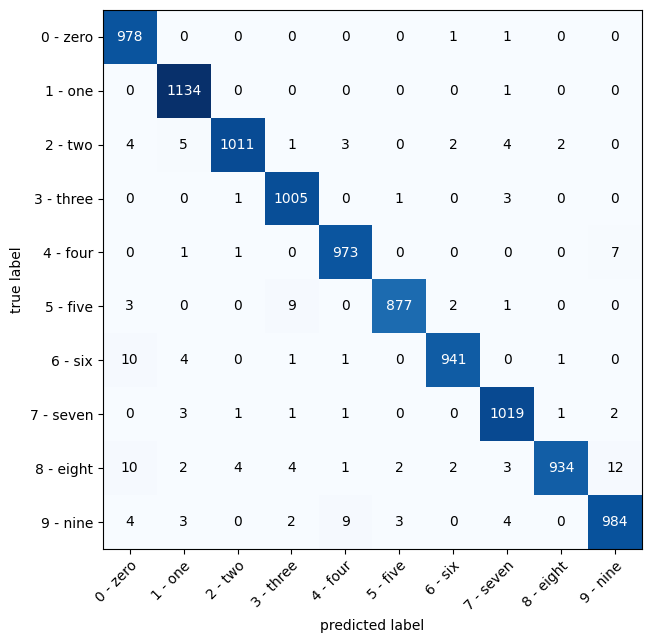

In [ ]:
#Setup a cofusion matrix
cfmatrix = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
cfmatrix_tensor = cfmatrix(preds=y_preds, target=test_data.targets)
#Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cfmatrix_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)